# Sumário

[1. O problema a ser enfrentado](#1.-O-problema-a-ser-enfrentado)

[2. Carregando os arquivos de dados](#2.-Carregando-os-arquivos-de-dados)

[2.1 Exploração, tratamento e limpeza dos dados](#2.1-Exploração,-tratamento-e-limpeza-dos-dados)

[3. Treinamento do modelo](#3.-Treinamento-do-modelo)

[3.1 Treinando o modelo com Naive Bayes](#3.1-Treinando-o-modelo-com-Naive-Bayes)

[3.2 Otimizando o modelo com RandomForest](#3.2-Otimizando-o-modelo-com-RandomForest)

[3.3 Utilizando o algoritmo de Regressão Logística](#3.3-Utilizando-o-algoritmo-de-Regressão-Logística)

[3.4 Conclusões](#3.4-Conclusões)

## 1. O problema a ser enfrentado

Nesse notebook irei utilizar dados obtidos do <a href=https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database> Kaggle </a> a respeito de pessoas com ancestralidade relacionada a tribo <a href=https://en.wikipedia.org/wiki/Pima_people>Pima</a>, uma tribo indígena estadunidense. 

Esse dataset nos permite analisar a possibilidade do desenvolvimento de diabetes em mulheres maiores de 21 anos de idade pertencentes a essa linhagem. Através dos resultados obtidos podemos obter os seguintes insights:

* Novas políticas públicas relacionadas a diabetes para o setor governamental;
* Previsão da demanda de medicamentos para empresas farmacêuticas;
* Auxilio na política de preços de medicamentes para empresas farmacêuticas;

Iremos tentar criar um modelo de ML que irá prever a possibilidade do desenvolvimento de diabetes com pelo menos 70% de acurácia.

## 2. Carregando os arquivos de dados

In [34]:
#Bibliotecas úteis para uma análise inicial dos dados.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
path = "pima-data.csv"
dataframe_or = pd.read_csv(path)

In [36]:
dataframe_or.head(3)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3780,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True


Cada coluna dentro do dataset apresenta o seguinte significado:

* num_preg -> Número de gestações
* glucose_conc -> Mede a concentração de glicose no sangue após duas horas em um teste de tolerância à glicose;
* diastolic_bp -> Pressão sanguínea;
* thickness -> Espessura da dobra cutânea do triceps (em mm);
* insulin -> Um soro de insulina que dura em torno de duas horas.
* bmi -> Indíce de massa corporal; 
* diab_pred -> Função "Diabetes Pedigree", que tenta obter a possibilidade do paciente desenvolver diabete baseando-se em dados familiares históricos;
* age -> Idade;
* skin -> (????) 
* diabetes -> Tem apenas dois valores, verdadeiro e falso. Basicamente são nossos dados de saída para o treinamento de um modelo de ML supervisionado.

In [37]:
dataframe_or.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_preg      768 non-null    int64  
 1   glucose_conc  768 non-null    int64  
 2   diastolic_bp  768 non-null    int64  
 3   thickness     768 non-null    int64  
 4   insulin       768 non-null    int64  
 5   bmi           768 non-null    float64
 6   diab_pred     768 non-null    float64
 7   age           768 non-null    int64  
 8   skin          768 non-null    float64
 9   diabetes      768 non-null    bool   
dtypes: bool(1), float64(3), int64(6)
memory usage: 54.9 KB


Agora, existe algum valor nulo neste dataset?

In [38]:
dataframe_or.isnull().any()

num_preg        False
glucose_conc    False
diastolic_bp    False
thickness       False
insulin         False
bmi             False
diab_pred       False
age             False
skin            False
diabetes        False
dtype: bool

### 2.1 Exploração, tratamento e limpeza dos dados

Como podemos ver, não. Todos os dados em cada coluna apresentam algum tipo de valores. Agora, como essas variáveis se correlacionam?

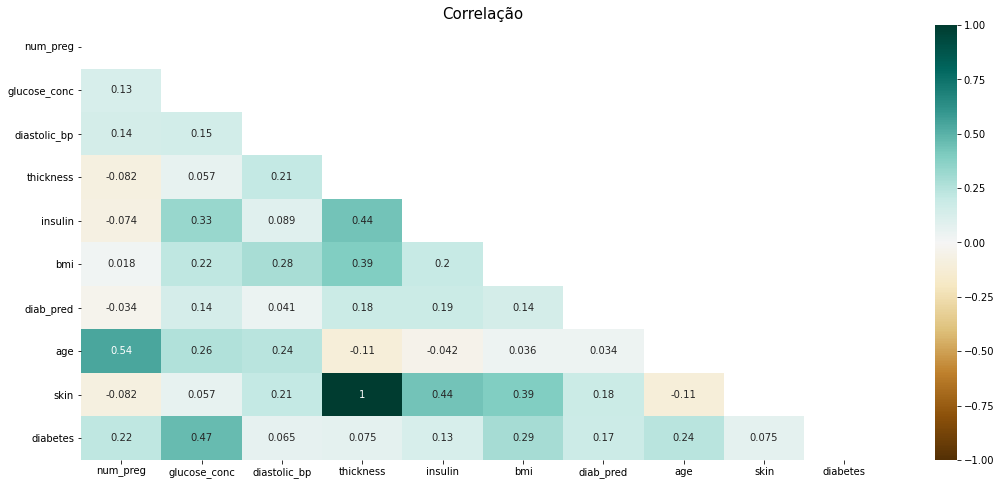

In [39]:
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(dataframe_or.corr(), dtype=bool))
heatmap = sns.heatmap(data = dataframe_or.corr(), mask = mask, annot = True, vmin = -1, vmax = 1, cmap = "BrBG")
heatmap.set_title("Correlação", fontdict={"size":15})
plt.show()

Podemos notar que o nível de glicose no sangue (glucose_conc), o índice de massa corporal (bmi), a idade (age), o número de gestações (num_preg) e o histórico familiar de diabetes (diab_pred) apresentam uma maior correlação com o desenvolvimento de diabetes. Com essa correlação em mãos via heatmap, podemos ter uma ideia de quais são as variáveis relevantes para a criação de um modelo de Machine Learning.

In [40]:
dataframe_or.corr()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
num_preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,-0.081673,0.221898
glucose_conc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.057326,0.466581
diastolic_bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.207371,0.065068
thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,1.000000,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.436785,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.392574,0.292695
diab_pred,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.183927,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,-0.113973,0.238356
skin,-0.081673,0.057326,0.207371,1.000000,0.436785,0.392574,0.183927,-0.113973,1.000000,0.074750
diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,0.074750,1.000000


Agora, vamos ver, visualmente, o desenvolvimento de diabetes utilizando alguns fatores.

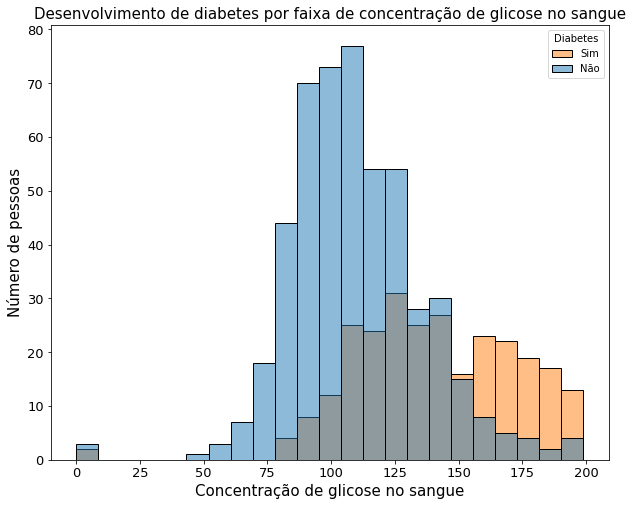

In [41]:
plt.figure(figsize=(10,8))
sns.histplot(data=dataframe_or, x="glucose_conc", hue="diabetes")
plt.xlabel("Concentração de glicose no sangue", fontdict={"size":15})
plt.ylabel("Número de pessoas", fontdict={"size":15})
plt.tick_params(axis="both", labelsize=13)
plt.legend(["Sim","Não"], title="Diabetes")
plt.title("Desenvolvimento de diabetes por faixa de concentração de glicose no sangue",fontdict={"size":15})
plt.show()

Vejamos que temos uma concentração de glicose no sangue "nula" no gráfico anterior e uma grande faixa que vai até em torno de 50 onde não temos nada, isso indica que talvez algum erro possa ter ocorrido na hora dos dados serem adicionados ao dataset. Esses tipos de valores são chamados de **valores missing ocultos**.

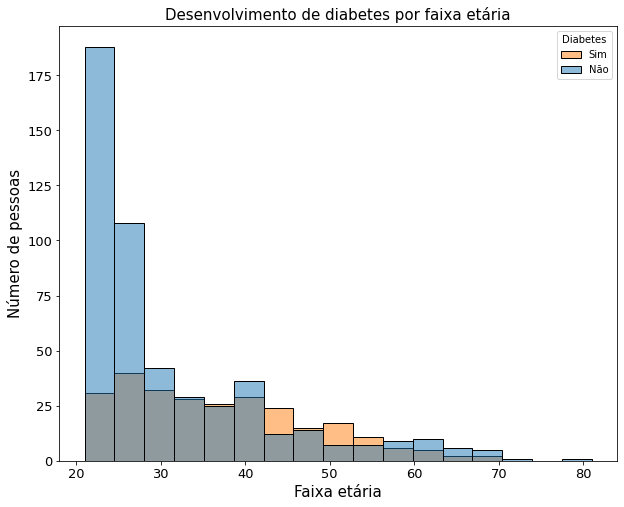

In [42]:
plt.figure(figsize=(10,8))
sns.histplot(data=dataframe_or, x="age", hue="diabetes")
plt.xlabel("Faixa etária", fontdict={"size":15})
plt.ylabel("Número de pessoas", fontdict={"size":15})
plt.tick_params(axis="both", labelsize=13)
plt.legend(["Sim","Não"], title="Diabetes")
plt.title("Desenvolvimento de diabetes por faixa etária",fontdict={"size":15})
plt.show()

Agora, vamos converter os valores da coluna diabetes de boleano para inteiro. Iremos fazer isso utilizando um mapeamento.

In [43]:
dataframe_or["Diabetes"] = dataframe_or["diabetes"].map({True: 1, False: 0})

In [44]:
dataframe_or.head(5)

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes,Diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3780,True,1
1,1,85,66,29,0,26.6,0.351,31,1.1426,False,0
2,8,183,64,0,0,23.3,0.672,32,0.0000,True,1
3,1,89,66,23,94,28.1,0.167,21,0.9062,False,0
4,0,137,40,35,168,43.1,2.288,33,1.3790,True,1


Esse passo é importante pois os modelos de ML não levam em consideração o texto.

Com isso feito, iremos observar como os dados target estão distribuídos nesse dataset.

In [60]:
num_true = len(dataframe_or.loc[dataframe_or["diabetes"]==True])
num_fals = len(dataframe_or.loc[dataframe_or["diabetes"]==False])
print("Número de casos verdadeiros: {0} ({1:2.2f}%)".format(num_true, (num_true/(num_true+num_fals)*100)))
print("Número de casos falsos     : {0} ({1:2.2f}%)".format(num_fals, (num_fals/(num_true+num_fals)*100)))

Número de casos verdadeiros: 268 (34.90%)
Número de casos falsos     : 500 (65.10%)


Como queremos fazer uma previsão de classificados o ideal seria termos um equilíbrio nas classes, tendo mais ou menos metade de cada valor de uma classe para outra.

## Splitting

Agora, iremos dividir os nosso dados em casos de treino e casos de teste.

In [61]:
from sklearn.model_selection import train_test_split # Biblioteca do sklearn que nos auxilia a fazer a divisão dos dados

In [69]:
#Vamos usar todos os dados, menos o nosso target e a variavel "skin", para o treinamento do modelo.
variavel_ind = ["num_preg", "glucose_conc", "diastolic_bp", "thickness", "insulin", "bmi", "diab_pred", "age"] 
variavel_dep = ["Diabetes"]

x_treino = dataframe_or[variavel_ind].values
y_treino = dataframe_or[variavel_dep].values

In [70]:
xt, xv, yt, yv = train_test_split(x_treino, y_treino, test_size = 0.3, random_state = 42) #Aqui vamos usar 30% dos dados para validação.

**Verificando o split**

In [76]:
print("Original True : {0} ({1:0.2f}%)".format(len(dataframe_or.loc[dataframe_or['Diabetes'] == 1]), 
                                               (len(dataframe_or.loc[dataframe_or['Diabetes'] ==1])/len(dataframe_or.index) * 100)))

print("Original False : {0} ({1:0.2f}%)".format(len(dataframe_or.loc[dataframe_or['Diabetes'] == 0]), 
                                               (len(dataframe_or.loc[dataframe_or['Diabetes'] == 0])/len(dataframe_or.index) * 100)))

Y_treino = yt
Y_teste = yv
print("")
print("Training True : {0} ({1:0.2f}%)".format(len(Y_treino[Y_treino[:] == 1]), 
                                               (len(Y_treino[Y_treino[:] == 1])/len(Y_treino) * 100)))

print("Training False : {0} ({1:0.2f}%)".format(len(Y_treino[Y_treino[:] == 0]), 
                                               (len(Y_treino[Y_treino[:] == 0])/len(Y_treino) * 100)))
print("")
print("Test True : {0} ({1:0.2f}%)".format(len(Y_teste[Y_teste[:] == 1]), 
                                               (len(Y_teste[Y_teste[:] == 1])/len(Y_teste) * 100)))

print("Test False : {0} ({1:0.2f}%)".format(len(Y_teste[Y_teste[:] == 0]), 
                                               (len(Y_teste[Y_teste[:] == 0])/len(Y_teste) * 100)))

Original True : 268 (34.90%)
Original False : 500 (65.10%)

Training True : 188 (35.01%)
Training False : 349 (64.99%)

Test True : 80 (34.63%)
Test False : 151 (65.37%)


**Tratando os valore missing ocultos**

In [80]:
for i in dataframe_or:
    if i == "Diabetes" or i == "diabetes":
        pass
    else: 
        print("Na coluna %s temos %s valores missing"%(i,len(dataframe_or.loc[dataframe_or[i]==0])))

Na coluna num_preg temos 111 valores missing
Na coluna glucose_conc temos 5 valores missing
Na coluna diastolic_bp temos 35 valores missing
Na coluna thickness temos 227 valores missing
Na coluna insulin temos 374 valores missing
Na coluna bmi temos 11 valores missing
Na coluna diab_pred temos 0 valores missing
Na coluna age temos 0 valores missing
Na coluna skin temos 227 valores missing


A coluna num_preg, que é o número de gestações, apresenta diversos valores 0 que dizem respeito a mulher não ter engravidado, então eles existirem é algo esperado. 

Na coluna glucose_conc, que é a concentração de glicose, temos 5 valores nulos que não são esperados e portanto são valores missing ocultos.

Na coluna diastolic_bp, que é relacionada a pressão sanguínea, temos 35 valores nulos, portanto eles também são valores missing ocultos.

Na coluna thickness, que é relacionada a espessura da dobra cutânea do triceps, temos 227 valores nulos, que não são esperados também. 

Para a coluna de insulina, temos 374 valores nulos.

Para a coluna bmi, que diz respeito a massa corporal, temos 11 valores missing, que também não são esperados. 

Por fim, a coluna skin não nos é importante.

Para resolver esse problema iremos utilizar a biblioteca sklearn e estaremos olhando para a classe <a href=https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html>SimpleImputer</a> (imputação).

In [83]:
from sklearn.impute import SimpleImputer

In [85]:
#Criamos o objeto
preenche_os = SimpleImputer(missing_values=0, strategy="mean")
#Agora, mudamos os dados de treino alterando os valores igual a zero pela média dos dados.
xt = preenche_os.fit_transform(xt)
xv = preenche_os.fit_transform(xv)

## 3. Treinamento do modelo

### 3.1 Treinando o modelo com Naive Bayes

In [87]:
from sklearn.naive_bayes import GaussianNB #Importo o modelo de ML

In [122]:
# Crio o modelo preditivo
modelo_gnb = GaussianNB()
# Treino o modelo preditivo
modelo_v1 = modelo_gnb.fit(xt,yt.ravel())

**Verificando a exatidão do modelo**

In [123]:
from sklearn import metrics # Importo todas as métricas pra verificar a exatidão no modelo do sklearn

In [124]:
pred_v1_treino = modelo_v1.predict(xt)
pred_v1_valida = modelo_v1.predict(xv)
print("A exatidão do modelo nos dados de treino é: {0:.4f}".format(metrics.accuracy_score(yt,pred_v1_treino)))
print("A exatidão do modelo nos dados de validação é: {0:.4f}".format(metrics.accuracy_score(yv,pred_v1_valida)))

A exatidão do modelo nos dados de treino é: 0.7542
A exatidão do modelo nos dados de validação é: 0.7359


Estranhamente, os dados de treino não estão muito bons, ou seja: o modelo não reproduz perfeitamente os dados de treino!

In [125]:
# Criando uma Confusion Matrix
cfm_v1 = metrics.confusion_matrix(yv, pred_v1_valida, labels=[1,0])

print("{0}".format(cfm_v1))
print("")

cfr_v1 = metrics.classification_report(yv, pred_v1_valida, labels=[1,0])
print("Classification Report")
print(cfr_v1)

[[ 52  28]
 [ 33 118]]

Classification Report
              precision    recall  f1-score   support

           1       0.61      0.65      0.63        80
           0       0.81      0.78      0.79       151

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231



### 3.2 Otimizando o modelo com RandomForest

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
modelo_v2 = RandomForestClassifier(random_state = 42)
modelo_v2.fit(xt, yt.ravel())

RandomForestClassifier(random_state=42)

In [101]:
#Verificação da acurácia do modelo usando dados de treino e dados de validação
pred_v2_treino = modelo_v2.predict(xt)
pred_v2_valida = modelo_v2.predict(xv)

print("A exatidão do modelo nos dados de treino é: {0:.4f}".format(metrics.accuracy_score(yt,pred_v2_treino)))
print("A exatidão do modelo nos dados de validação é: {0:.4f}".format(metrics.accuracy_score(yv,pred_v2_valida)))

A exatidão do modelo nos dados de treino é: 1.0000
A exatidão do modelo nos dados de validação é: 0.7403


Podemos notar uma pequena melhoria nos dados de validação e uma melhoria imensa nos dados de treino, isto é: o modelo consegue descrever os dados de treino perfeitamente, diferentemente do que ocorreu com o modelo anterior.

In [102]:
# Criando uma Confusion Matrix
cfm_v2 = metrics.confusion_matrix(yv, pred_v2_valida, labels=[1,0])

print("{0}".format(cfm_v2))
print("")

cfr_v2 = metrics.classification_report(yv, pred_v2_valida, labels=[1,0])
print("Classification Report")
print(cfr_v2)

[[ 52  28]
 [ 32 119]]

Classification Report
              precision    recall  f1-score   support

           1       0.62      0.65      0.63        80
           0       0.81      0.79      0.80       151

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



### 3.3 Utilizando o algoritmo de Regressão Logística

In [105]:
from sklearn.linear_model import LogisticRegression

In [118]:
#Treinamento do modelo
modelo_v3 = LogisticRegression(C = 0.7, random_state= 42, max_iter=1000) #Esse algoritmo é um algoritmo de CLASSIFICAÇÃO!
modelo_v3.fit(xt, yt.ravel())

LogisticRegression(C=0.7, max_iter=1000, random_state=42)

In [119]:
#Predições e teste!
pred_v3_treino = modelo_v3.predict(xt)
pred_v3_valida = modelo_v3.predict(xv)

print("A exatidão do modelo nos dados de treino é: {0:.4f}".format(metrics.accuracy_score(yt,pred_v3_treino)))
print("A exatidão do modelo nos dados de validação é: {0:.4f}".format(metrics.accuracy_score(yv,pred_v3_valida)))

A exatidão do modelo nos dados de treino é: 0.7877
A exatidão do modelo nos dados de validação é: 0.7359


Novamente, nós temos um modelo que não descreve perfeitamente os dados de teste.

In [120]:
# Criando uma Confusion Matrix
cfm_v3 = metrics.confusion_matrix(yv, pred_v3_valida, labels=[1,0])

print("{0}".format(cfm_v3))
print("")

cfr_v3 = metrics.classification_report(yv, pred_v3_valida, labels=[1,0])
print("Classification Report")
print(cfr_v3)

[[ 47  33]
 [ 28 123]]

Classification Report
              precision    recall  f1-score   support

           1       0.63      0.59      0.61        80
           0       0.79      0.81      0.80       151

    accuracy                           0.74       231
   macro avg       0.71      0.70      0.70       231
weighted avg       0.73      0.74      0.73       231



### 3.4 Conclusões

In [121]:
print("A acurácia de cada modelo nos dados de validação é:")
print("Modelo 1: %s"%(metrics.accuracy_score(yv,pred_v1_valida)))
print("Modelo 2: %s"%(metrics.accuracy_score(yv,pred_v2_valida)))
print("Modelo 3: %s"%(metrics.accuracy_score(yv,pred_v3_valida)))

A acurácia de cada modelo é:
Modelo 1: 0.7359307359307359
Modelo 2: 0.7402597402597403
Modelo 3: 0.7359307359307359


In [127]:
print("A acurácia de cada modelo nos dados de treino é:")
print("Modelo 1: %s"%(metrics.accuracy_score(yt,pred_v1_treino)))
print("Modelo 2: %s"%(metrics.accuracy_score(yt,pred_v2_treino)))
print("Modelo 3: %s"%(metrics.accuracy_score(yt,pred_v3_treino)))

A acurácia de cada modelo nos dados de treino é:
Modelo 1: 0.7541899441340782
Modelo 2: 1.0
Modelo 3: 0.7877094972067039


Podemos notar que embora os resultados na validação dos modelos 1 e 3 sejam os mesmos, o resultado no treino do modelo não é. 

Observando os resultados da validação, o modelo que melhor descreve os dados é o segundo modelo, de Floresta Aleatória (Random Florest).

**Fazendo previsões com o modelo treinado** 

In [130]:
# Salvamos o modelo treinado caso queiramos utilizá-lo futuramente;
import pickle
filename = 'Modelo_Diabetes_treinado.sav'
pickle.dump(modelo_v2,open(filename,'wb'))

In [132]:
# Carregamos o modelo já treinado. Aqui devemos ter novos valores de xt e yt preparados com o devido cuidado no processo de limpeza e transformação
loaded_model = pickle.load(open(filename,'rb'))
resultado1 = loaded_model.predict(xt[15].reshape(1,-1))
resultado2 = loaded_model.predict(xt[18].reshape(1,-1))
print(resultado1)
print(resultado2)

[0]
[0]
